In [ ]:
!pip install -q kaggle
!pip install transformers

In [ ]:
from transformers import BertTokenizer
import json

from transformers import (
    EncoderDecoderModel,
    PreTrainedTokenizer,
    AutoTokenizer,
    DataCollatorForSeq2Seq
)
from torch.utils.data import Dataset, DataLoader
import torch

## Kaggle에서 JIT 데이터 셋 가져오기

1. Kaggle 접속 후 로그인 : https://www.kaggle.com/
2. Account Tab 클릭\
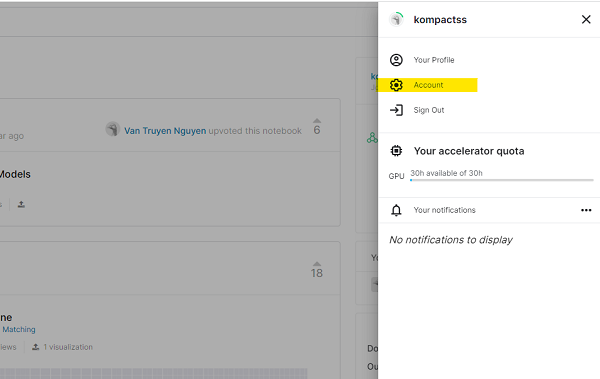

3. API Token 발급\
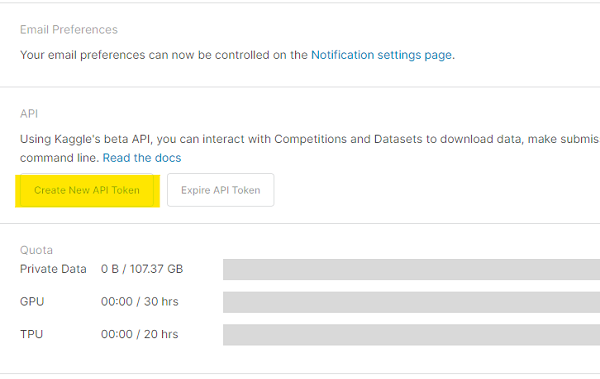

4. 다운로드된 kaggle.json 파일 colab 세션 저장소에 업로드

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bryanpark/jit-dataset

In [ ]:
!unzip '/content/jit-dataset.zip'

## Jebert Model 및 Toekenizer 다운로드

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = EncoderDecoderModel.from_pretrained('kompactss/JeBert_je_ko')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('kompactss/JeBert_je_ko')

In [ ]:
model.to(device)
model.eval()

## 테스트 데이터셋 준비

In [ ]:
# 제주어 - 표준어 성능 확인 시 (Jebert_je_ko)
src_file_path = 'je.test'
trg_file_path = 'ko.test'

# 표준어 - 제주어 성능 확인 시 (Jebert_ko_je)
#src_file_path = 'ko.test'
#trg_file_path = 'je.test'

data = []
data_answer = []
with open(src_file_path, 'r') as fd:
    for line in fd.readlines():
        data.append(line[:-1])
with open(trg_file_path, 'r') as fd:
    for i, line in enumerate(fd.readlines()):
        data_answer.append(line[:-1])

In [ ]:
len(data), len(data_answer)

## DataLoader에 테스트 데이터셋 로드

In [ ]:
from torch.utils.data import Dataset, DataLoader

class DatasetRetriever(Dataset):
    def __init__(self, features):
        super(DatasetRetriever, self).__init__()
        self.features = features

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):   
        feature = self.features[index]
        embedding = tokenizer(feature, truncation=True, max_length=512, return_attention_mask=False, return_token_type_ids=False)
        return {'input_ids' : embedding['input_ids']}

In [ ]:
test_dataset = DatasetRetriever(data)

In [ ]:
collator = DataCollatorForSeq2Seq(tokenizer, model)

test_loader = DataLoader(
    test_dataset, 
    batch_size=128, # GPU 성능에 따라 batch size를 낮춰도 됨
    shuffle=False,
    collate_fn=collator,
    num_workers=1)

## 모델 예측값 얻기 

In [ ]:
from tqdm import tqdm

def get_prediction(text):
    embeddings = tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
    embeddings.to(device)
    output = model.generate(**embeddings, max_length=256, bos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)[0, 1:-1].cpu()
    return tokenizer.decode(output[1:])

def get_predictions(data):
    result = []
    for batch in tqdm(data):
        batch = {key: value.to(device) for key, value in batch.items()}
        output = model.generate(batch['input_ids'], max_length=256).cpu()
        try:
            outputs = [tokenizer.decode(item[2:item.tolist().index(tokenizer.sep_token_id)]) for item in output]
        except ValueError:
            outputs = [tokenizer.decode(item[2:]) for item in output]
        result.extend(outputs)
    return result

In [ ]:
test_pred = get_predictions(test_loader)

In [ ]:
import pickle

with open('best_model_je_test_pred.pkl', 'wb') as f:
    pickle.dump(test_pred, f)

# 정답값
with open('best_model_ko_data_answer.pkl', 'wb') as f:
    pickle.dump(data_answer, f)

## Bleu score 구하기

In [ ]:
import nltk

BLEUscore_sum = []
for i in range(len(test_pred)):
    hypothesis = test_pred[i]
    reference = data_answer[i]
    BLEU = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
    BLEUscore_sum.append(BLEU)

In [ ]:
avg = sum(BLEUscore_sum, 0.0) / len(BLEUscore_sum)
print(avg)

#Bleu score(JIT Testset)


### 제주어 to 표준어
    1. only jit : 71.9
    2. jit + ai_hub : 59.7
    3. jit + preprocessed ai_hub : 74.3
    4. jit + preprocessed ai_hub_v2 :  74.3
### 표준어 to 제주어
    1. only jit : 59.0
    2. jit + ai_hub : 41.3
    3. jit + preprocessed ai_hub : 60.7
    4. jit + preprocessed ai_hub_v2 :  61.1